In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
import pickle
import numpy as np

# s1.0 = male probably

bsnipdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))

fc = []
race = []
sex = []
age = []
sz = []
subids = []

a,b = np.triu_indices(264,1)

for sub in demo['Age_cal']:
    diag = demo['DXGROUP_1'][sub]
    if diag not in ['SZP', 'NC']:
        continue
    ra = demo['Race'][sub]
    if ra not in ['AA', 'CA']:
        continue
    se = demo['sex'][sub]
    diag = diag == 'SZP'
    ra = ra == 'AA'
    se = se == 's1.0'
    ag = demo['Age_cal'][sub]
    p = np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy')
    p = remap(vec2mat(p))[a,b]
    age.append(ag)
    sex.append(se)
    race.append(ra)
    sz.append(diag)
    fc.append(p)
    subids.append(sub)

fc = np.stack(fc)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
sz = np.array(sz).astype('int')
age = np.array(age)

print(max(age))
print(min(age))
print(np.mean(age))
print(np.std(age))
age = (age-np.mean(age))/np.std(age)

print([a.shape for a in [fc, sz, race, sex, age]])

64.0
15.0
36.92098765432099
12.335582538145621
[(405, 34716), (405,), (405,), (405,), (405,)]


In [3]:
from sklearn.linear_model import Ridge, LogisticRegression
import torch

age_reg = Ridge(alpha=100).fit(fc, age)
age_w = torch.from_numpy(age_reg.coef_).float().cuda()
age_i = age_reg.intercept_
sex_reg = LogisticRegression(C=100, max_iter=500).fit(fc, sex)
sex_w = torch.from_numpy(sex_reg.coef_[0]).float().cuda()
sex_i = sex_reg.intercept_[0]
race_reg = LogisticRegression(C=100, max_iter=500).fit(fc, race)
race_w = torch.from_numpy(race_reg.coef_[0]).float().cuda()
race_i = race_reg.intercept_[0]
sz_reg = LogisticRegression(C=100, max_iter=500).fit(fc, sz)
sz_w = torch.from_numpy(sz_reg.coef_[0]).float().cuda()
sz_i = sz_reg.intercept_[0]

print(age_i, sex_i, race_i, sz_i)

0.8749722627654616 0.016462112803870683 0.006857627907262022 0.04760862089526853


In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# import random

# class VAE(nn.Module):
#     def __init__(self, fcd, ld, matsz, rank):
#         super(VAE, self).__init__()
#         self.fcd = fcd
#         self.ld = ld
#         self.matsz = matsz
#         self.rank = rank
#         self.enc1 = nn.Linear(fcd, 1000).float().cuda()
#         self.enc2 = nn.Linear(1000, ld).float().cuda()
#         self.dec1 = nn.Linear(ld+4, 1000).float().cuda()
#         self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

#     def enc(self, x):
#         x = F.relu(self.enc1(x))
#         z = self.enc2(x)
#         return z

#     def gen(self, n):
#         return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
#     def dec(self, z, age, sex, race, sz):
#         z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), sz.unsqueeze(1)], dim=1)
#         x = F.relu(self.dec1(z))
#         x = self.dec2(x)
#         x = x.reshape(len(z), self.matsz, self.rank)
#         x = torch.einsum('abc,adc->abd', x, x)
#         return x

#     def vectorize(self, x):
#         a,b = np.triu_indices(self.matsz, 1)
#         return x[:,a,b]

# vae = VAE(34716, 30, 264, 5)
# vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/BSNIP/vae_1000_z30_cov4_264_rank5.torch'))
# vae.eval()

# print('Done')

Done


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+4, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, fcd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, sz):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), sz.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, age, sex, race, sz):
    age = age - torch.mean(age)
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    sz = sz - torch.mean(sz)
    agep = torch.einsum('n,nz->z', age, z)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    szp = torch.einsum('n,nz->z', sz, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_age = rmse(agep, tgt)
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    loss_sz = rmse(szp, tgt)
    return loss_age + loss_sex + loss_race + loss_sz

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(fc.shape[-1], 30)
optim = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=5e-5)

x = torch.from_numpy(fc).float().cuda()
age_t = torch.from_numpy(age).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()
sz_t = torch.from_numpy(sz).float().cuda()

nepochs = 2000
pperiod = 50

ce = nn.CrossEntropyLoss()

for e in range(nepochs):
    # Reconstruct
    optim.zero_grad()
    z = vae.enc(x)
    y = vae.dec(z, age_t, sex_t, race_t, sz_t)
    lossC, lossmu, _, _ = latent_loss(z)
    lossDecor = decor_loss(z, age_t, sex_t, race_t, sz_t)
    lossrec = rmse(x, y)
    # Generate
    ag = torch.ones(100).float().cuda()*torch.randn(1)[0]
    sx = torch.ones(100).long().cuda()*random.randint(0,1)
    rc = torch.ones(100).long().cuda()*random.randint(0,1)
    ss = torch.ones(100).long().cuda()*random.randint(0,1)
    z = vae.gen(100)
    y = vae.dec(z, ag, sx, rc, ss)
    ag_hat = y@age_w + age_i
    sx_hat = y@sex_w + sex_i
    rc_hat = y@race_w + race_i
    sz_hat = y@sz_w + sz_i
    age_loss = rmse(ag_hat, ag)
    sex_loss = ce(torch.stack([-sx_hat, sx_hat], dim=1), sx)
    race_loss = ce(torch.stack([-rc_hat, rc_hat], dim=1), rc)
    sz_loss = ce(torch.stack([-sz_hat, sz_hat], dim=1), ss)
    (lossC+lossmu+lossrec+lossDecor+0.001*age_loss+0.001*sex_loss+0.001*race_loss+0.001*sz_loss).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(lossC)} {pretty(lossmu)} {pretty(lossDecor)} {pretty(lossrec)} {pretty(age_loss)} {pretty(sex_loss)} {pretty(race_loss)}' + 
             f' {pretty(sz_loss)}')

print('Done')

0 7.1523 0.0551 3.2003 0.3224 1.3497 2.3862 1.9687 0.6983
50 7.2291 0.0519 0.449 0.2591 0.0991 0.0 0.0 0.0
100 7.1565 0.052 0.4521 0.2152 0.2252 0.0 0.0003 0.0002
150 7.0902 0.0527 0.4923 0.2007 0.0532 0.0001 0.0003 0.0001
200 7.0337 0.054 0.3989 0.1953 0.2563 0.0001 0.0109 0.0
250 6.9031 0.0544 0.4411 0.1906 0.0435 0.0 0.0001 0.0002
300 6.7552 0.0538 0.5852 0.1866 0.0506 0.0001 0.0 0.0
350 6.6054 0.0533 0.5747 0.1834 0.0673 0.0012 0.0001 0.0004
400 6.4154 0.053 0.5664 0.1804 0.0446 0.0 0.0 0.0004
450 6.2221 0.0538 0.3362 0.1781 0.0771 0.0 0.0001 0.0002
500 6.0546 0.0542 0.4211 0.1755 0.1761 0.0001 0.0 0.0
550 5.8985 0.0538 0.4718 0.1734 0.061 0.0028 0.001 0.0004
600 5.7507 0.0546 0.5748 0.1715 0.0351 0.0004 0.0 0.0
650 5.5854 0.0543 0.6615 0.1698 0.0656 0.0 0.0001 0.0
700 5.3793 0.0543 0.5511 0.1684 0.0593 0.0003 0.0 0.0
750 5.1501 0.0545 0.4804 0.1669 0.0589 0.0 0.0001 0.0
800 4.9181 0.0544 0.7474 0.1658 0.1076 0.0 0.0 0.0
850 4.6797 0.0539 0.6764 0.1641 0.1344 0.0003 0.0007 0.0
900 

/tmp/ipykernel_290383/3122563825.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


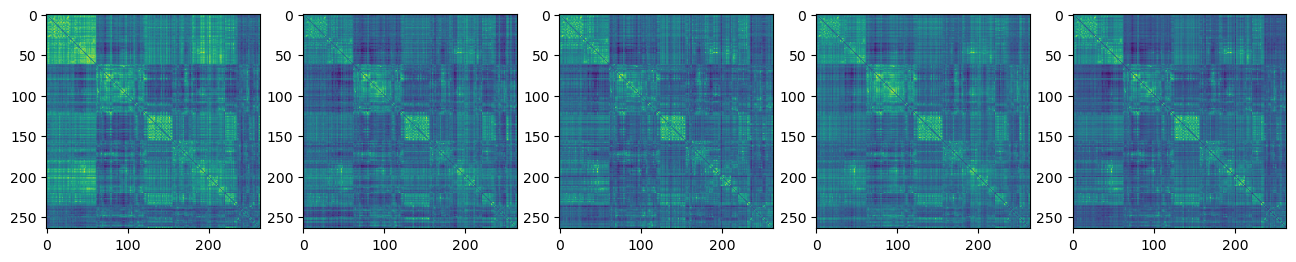

In [46]:
import matplotlib.pyplot as plt

n = 1000

with torch.no_grad():
    ag = 0*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    ss = 0*torch.ones(n).float().cuda()
    z = vae.gen(n)
    y = vae.dec(z, ag, sx, rc, ss)
    y = y.detach().cpu().numpy()

fig, ax = plt.subplots(1,5,figsize=(16,4))
ym = np.mean(y, axis=0)
ym2 = ym

ax[0].imshow(vec2mat(y[0]))
ax[1].imshow(vec2mat(y[1]))
ax[2].imshow(vec2mat(y[2]))
ax[3].imshow(vec2mat(y[3]))
ax[4].imshow(vec2mat(ym))

fig.show()

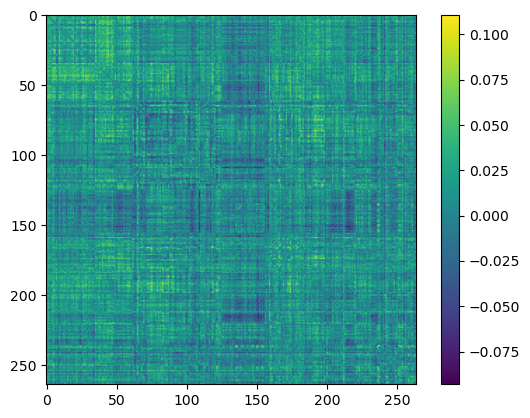

In [53]:
# plt.imshow(vec2mat(ym1-ym2))
plt.imshow(vec2mat(np.mean(fc[sex == 1], axis=0)-np.mean(fc[sex == 0], axis=0)))
plt.colorbar()
plt.show()

In [37]:
# Try the sz prediction from latents without sz taken out
# Even though no train/test split for making latents

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge

with torch.no_grad():
    x = torch.from_numpy(fc).float().cuda()
    z = vae.enc(x).detach().cpu().numpy()

from sklearn.model_selection import train_test_split

errs = []
nulls = []

for _ in range(20):
    xtr, xt, ytr, yt = train_test_split(z, age, train_size=0.9)
    reg = Ridge(alpha=1).fit(xtr, ytr)
    yhat = reg.predict(xt)
    err = rmse(yhat, yt, np.mean)
    null = rmse(np.mean(yt), yt, np.mean)
    # reg = LogisticRegression(C=100, max_iter=500).fit(xtr, ytr)
    # yhat = reg.predict(xt)
    # err = np.mean(yhat == yt)
    # null = np.mean(yt)
    if null < 0.5:
        null = 1-null
    errs.append(err)
    nulls.append(null)
    print(err, null)

print('---')
print(np.mean(errs), np.mean(nulls))

1.5870294677898913 1.1211764926501568
1.037106836762667 0.9451433463434378
1.4149495121738578 0.9771061758358224
1.2285152659824023 1.0578920771211546
1.462371045321623 1.0449114971407176
1.1280975460851261 1.0604868218501569
0.9767076136744768 0.8824458504382166
1.0443847017585375 0.9800544837584534
1.0077614559659798 0.8791658249873898
1.241694176636951 1.1672472398554972
1.0616274936958017 0.8959041147714013
1.1457924893348537 1.0447880238417264
1.1972776868264154 0.9980236917342042
1.3366587936428398 0.9776541625176864
1.0917803751752728 0.8244632550161856
1.1188941785710622 1.0534815588829816
0.9141943423336992 0.8202846387421765
1.139810171545286 0.984567604859445
1.2231221969643336 1.0499614005766364
1.0126546711501572 0.8535026305379143
---
1.1685215010695615 0.9809130445730683


In [54]:
# Save VAE

torch.save(vae.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/BSNIP/vae_1000_z30_cov4.torch')

print('Done')

Done


In [55]:
dct = dict(ld=30, rois=264, rank=5, inv_sigma=10**0.5)

dct['enc1_w'] = vae.enc1.weight.T.detach().cpu().numpy()
dct['enc1_b'] = vae.enc1.bias.detach().cpu().numpy()
dct['enc2_w'] = vae.enc2.weight.T.detach().cpu().numpy()
dct['enc2_b'] = vae.enc2.bias.detach().cpu().numpy()
dct['dec1_w'] = vae.dec1.weight.T.detach().cpu().numpy()
dct['dec1_b'] = vae.dec1.bias.detach().cpu().numpy()
dct['dec2_w'] = vae.dec2.weight.T.detach().cpu().numpy()
dct['dec2_b'] = vae.dec2.bias.detach().cpu().numpy()

pickle.dump(dct, open('/home/anton/Documents/Tulane/Research/fc-ts-vae/data/vae_bsnip_1000_z30_cov4_2.pkl', 'wb'))

print('Done')

Done


In [56]:
dct['dec1_w'].shape

(34, 1000)

In [59]:
import scipy.stats as stats

with torch.no_grad():
    zz = vae.enc(torch.from_numpy(fc).float().cuda())
    zz = zz.detach().cpu().numpy()

def corr(z, y):
    z = z - np.mean(z, axis=0, keepdims=True)
    y = y - np.mean(y)
    xx = np.einsum('na,na->a', z, z)
    yy = np.einsum('n,n->', y, y)
    xy = np.einsum('na,n->a', z, y)
    rho = xy/((xx*yy)**0.5)
    n = z.shape[0]
    m = z.shape[1]
    df = n-2
    t = rho*(df/(1-rho**2))**0.5
    t[t < 0] = -t[t < 0]
    p = (1-stats.t.cdf(t, df))*2
    p *= m
    p[p > 1] = 1
    return rho, p

def to_cat(y):
    cats = set()
    for yy in y:
        cats.add(yy)
    cats = list(cats)
    yp = np.zeros(len(y))
    for j,yy in enumerate(y):
        for i,cat in enumerate(cats):
            if yy == cat:
                yp[j] = i
    return yp

n = 0
m = 0
for key in demo.keys():
    z = []
    y = []
    for i,sub in enumerate(subids):
        if sub in demo[key]:
            z.append(zz[i])
            y.append(demo[key][sub])
    if len(z) == 0:
        continue
    n += 1
    nn = len(z)
    z = np.stack(z)
    y = np.array(y)
    if isinstance(y[0], str):
        y = to_cat(y)
    rho, p = corr(z, y)
    if np.any(p < 0.05):
        m += 1
        print(key, 'yes', min(p), nn)
print(n, m)

MED_ANTIP_FIRSTGEN_SEC yes 0.021792662972184296 398
PANSS_PosTotal yes 0.009826986262189141 182
PANSS_NegTotal yes 0.029550046984210265 182
PANSS_GenTotal yes 0.0010928440148627594 182
PANSS_Total yes 0.00032936532980976096 182
sz_subtype yes 1.697055029836747e-07 185
33 6


/tmp/ipykernel_290383/1432548388.py:13: RuntimeWarning: invalid value encountered in divide
  rho = xy/((xx*yy)**0.5)


In [8]:
list(demo.keys())

['DXGROUP_1',
 'DXGROUP_2',
 'sex',
 'ethnic',
 'Race',
 'handed',
 'MED_PSYCHOTROPIC',
 'MED_ANTIP_ANY_PRI',
 'MED_ANTIP_FIRSTGEN_SEC',
 'MED_ANTIP_SECONDGEN_SEC',
 'MED_ANTID_ANY_PRI',
 'MED_ANTID_TRICYCLIC_SEC',
 'MED_ANTID_MAOI_SEC',
 'MED_ANTID_SSRI_SEC',
 'MED_ANTID_MISC_SEC',
 'MED_MOOD_ANY_PRI',
 'MED_MOOD_LITHIUM_SEC',
 'MED_MOOD_ANTICONVUL_SEC',
 'MED_ANX_HYP_PRI',
 'MED_ANTICHOL_PRI',
 'MED_CENT_ACTIVE_PRI',
 'MED_STIMULANTS_PRI',
 'Age_cal',
 'I2a',
 'PANSS_PosTotal',
 'PANSS_NegTotal',
 'PANSS_GenTotal',
 'PANSS_Total',
 'pt_hollscore',
 'mo_hollscore',
 'fa_hollscore',
 'Family_hollscore',
 'sz_subtype',
 'sad_subtype',
 'bp_subtype']